In [3]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Environments

In [5]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [4]:
"""
references:  stanford cs231n assignment2
"""

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 32, 32, 3)
Train labels shape:        (49000,)
Validation data shape:     (1000, 32, 32, 3)
Validation labels shape:   (1000,)
Test data shape:           (10000, 32, 32, 3)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Visualize Examples

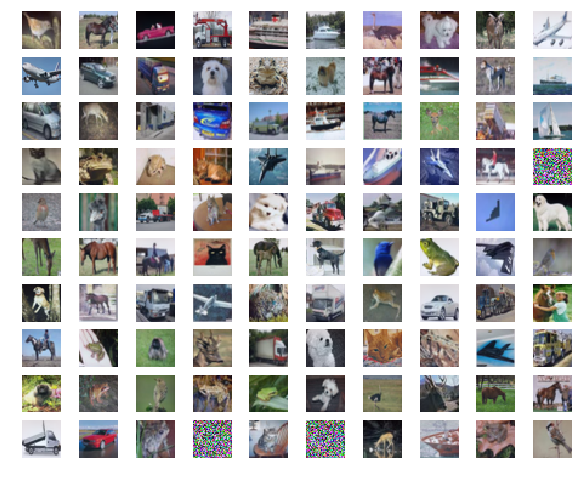

In [27]:
img = X_train[np.random.randint(0, 49000, size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()

# Model

In [45]:
def conv2d(x, W):
    """a 2-D convolution layer with full stride """
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    """max pool by 2x2 """
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)


def experts_model(X):
    """
    Deep NN :
        (1) 5x5 Convolutional Layer with 32 filters and stride of 1
        (2) ReLU Activation Layer
        (3) 2x2 Max Pooling layer with a stride of 2
    
        (4) 5x5 Convolutional Layer with 64 filters and stride of 1
        (5) ReLU Activation Layer
        (6) 2x2 Max Pooling layer with a stride of 2
    
        (7) Affine layer with 1024 output units
        (8) ReLU Activation Layer
    
        (9) Dropout layer
    
        (10) Affine layer from 1024 input units to 10 outputs
        
    Args:
        X: an input tensor with  dimensions (None, 28X28=784)
        
    Returns:
        A tuple (y_out, keep_prob)
       
    """
   
    ## (1) 5x5 Convolutional Layer with 32 filters and stride of 1
    ## (2) ReLU
    W_conv1 = weight_variable([5, 5, 3, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)
    
    ## (3) 2x2 Max Pooling
    h_pool1 = max_pool_2x2(h_conv1)    ## 16 X 16 X 32

    
    ## (4) 5x5 conv with 64 filters and stride of 1
    ## (5) ReLU
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)   
    
    ## (6) 2x2 Max Pooling
    h_pool2 = max_pool_2x2(h_conv2)    ## 8 x 8 x 64

    
    ## (7) Affine layer with 1024 output units
    ## (8) ReLU Activation Layer
    W_fc1 = weight_variable([8 * 8 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])   
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    ## (9) dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    ## (10) Affine layer from 1024 input units to 10 outputs
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_out = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    return y_out, keep_prob
    
def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from cifar10  
        label_set: labels from cifar10
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    
    
    return data_set[idx, :], label_set[idx]

def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)
    
    return tf.reduce_mean(tf.cast(correct, tf.float32))
    

# Graph

In [43]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])


class configs:
    batch_size = 512
    learning_rate = 2e-4
    print_every = 20
    epochs = 4
    model_path_name = "./models/experts_model.ckpt"
    
    
## loss
y_out, keep_prob = experts_model(X)
accuracy = evaluation(y_out, y)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = y_out, labels = tf.one_hot(y,10))
mean_loss = tf.reduce_mean(cross_entropy)

## train
train_step = tf.train.AdamOptimizer(configs.learning_rate).minimize(mean_loss) 

saver = tf.train.Saver()

# Training

Iter         1, training batch accuracy 0.132812
Iter        21, training batch accuracy 0.224609
Iter        41, training batch accuracy 0.28125
Iter        61, training batch accuracy 0.314453
Iter        81, training batch accuracy 0.306641
Epoch 1, Overall validation loss = 137.61819458, validation acuracy = 0.330000013113
Epoch 1, best validation accuracy = 0.330000013113


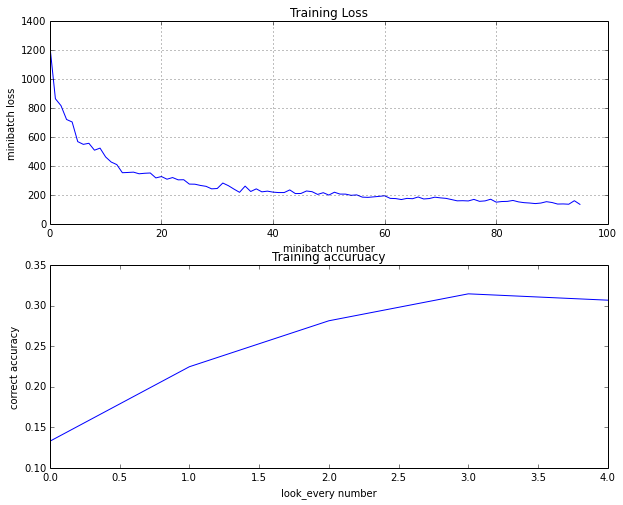

Iter        97, training batch accuracy 0.333984
Iter       117, training batch accuracy 0.345703
Iter       137, training batch accuracy 0.355469
Iter       157, training batch accuracy 0.375
Iter       177, training batch accuracy 0.345703
Epoch 2, Overall validation loss = 84.5411987305, validation acuracy = 0.33599999547
Epoch 2, best validation accuracy = 0.33599999547


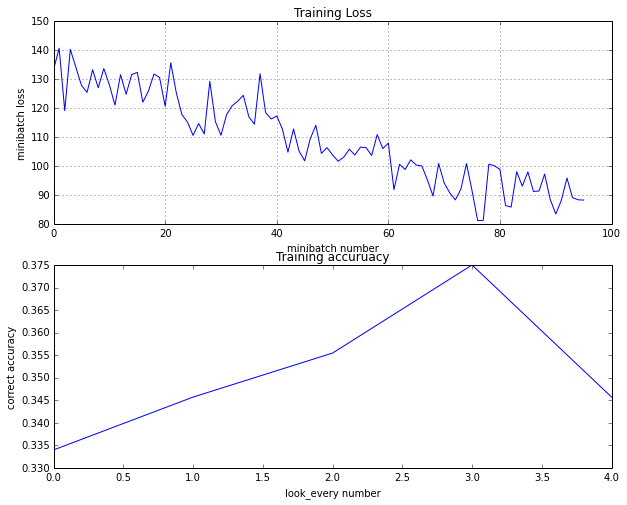

Iter       193, training batch accuracy 0.378906
Iter       213, training batch accuracy 0.382812
Iter       233, training batch accuracy 0.410156
Iter       253, training batch accuracy 0.376953
Iter       273, training batch accuracy 0.349609
Epoch 3, Overall validation loss = 56.1417274475, validation acuracy = 0.377999991179
Epoch 3, best validation accuracy = 0.377999991179


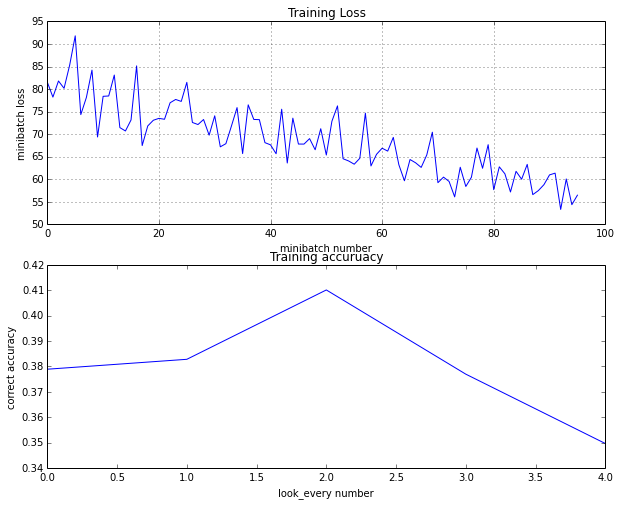

Iter       289, training batch accuracy 0.423828
Iter       309, training batch accuracy 0.384766
Iter       329, training batch accuracy 0.371094
Iter       349, training batch accuracy 0.392578
Iter       369, training batch accuracy 0.361328
Epoch 4, Overall validation loss = 40.1426734924, validation acuracy = 0.375
Epoch 4, best validation accuracy = 0.377999991179


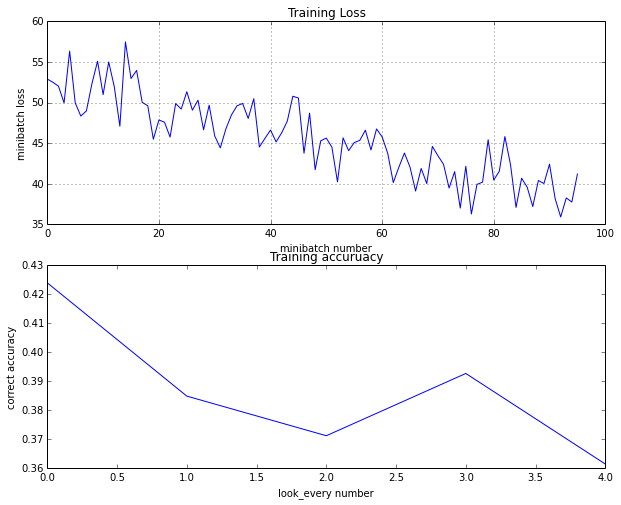

test set accuracy:    0.3624


In [44]:
init = tf.global_variables_initializer()

sess = tf.Session()
with tf.device("/gpu:0") as dev:
    sess.run(init)
 
    iter_cnt = 1
    best_val_acc = -1
    for e in range(configs.epochs):
        validing_now = False
        
        train_indicies = np.arange(X_train.shape[0])
        np.random.shuffle(train_indicies)

        losses = []
        train_accuracies = []    
        for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
            batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    
                 
        
            if i % configs.print_every == 0:
                train_accuracy = sess.run(accuracy, feed_dict = {X: batch_X, y: batch_y, keep_prob: 1.0})
                train_accuracies.append(train_accuracy)
                print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))
        
            loss, _ = sess.run([mean_loss, train_step], feed_dict={X: batch_X, y: batch_y, keep_prob: 1.0})
            losses.append(loss)
            
            iter_cnt += 1
            
        validing_now = True    
        if validing_now:
            feed_val_dict = {X: X_val, y: y_val, keep_prob: 1.0}    
            val_loss, val_acc = sess.run([mean_loss, accuracy], feed_dict = feed_val_dict)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                saver.save(sess, configs.model_path_name)

            print("Epoch {2}, Overall validation loss = {0}, validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
        ## visualizing loss and accuracy 
        plt.subplot(2, 1, 1)
        plt.plot(losses)
        plt.grid(True)
        plt.title('Training Loss')
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
    
        plt.subplot(2, 1, 2)
        plt.plot(train_accuracies)
        plt.title("Training accuruacy")
        plt.xlabel("look_every number")
        plt.ylabel("correct accuracy")
    
    
        plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    feed_dict = {X: X_test, y: y_test, keep_prob: 1.0}
    test_acc = sess.run(accuracy, feed_dict = feed_dict)
        
    print("test set accuracy:   ", test_acc)